# Imports

In [13]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output
plt.set_cmap('cividis')


from scipy import interpolate

#specific Neural Network imports

import tensorflow as tf
import keras
import keras_tuner
import keras.backend as K

from keras_tuner import RandomSearch, Hyperband, GridSearch, BayesianOptimization, HyperModel, Objective, Tuner, HyperParameters
from keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, save_model


#imports for scikit learn, for general ML techniques


from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.decomposition import PCA

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()



<Figure size 640x480 with 0 Axes>

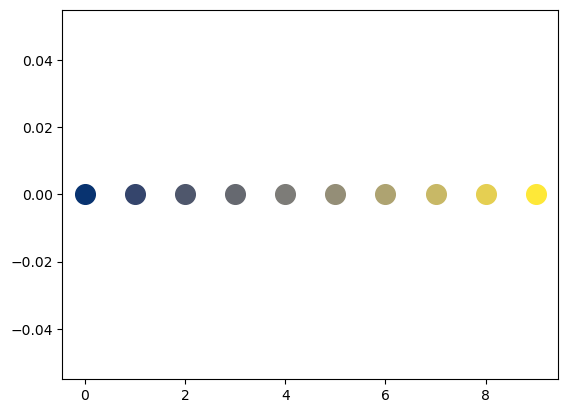

In [15]:
#Creating some colors for use throughout the notebook
cmap = matplotlib.cm.get_cmap('cividis')
colors = [cmap(i) for i in np.arange(0.1, 1.1, 0.1)]
for i, col in enumerate(colors):
  plt.scatter(i, 0, color=colors[i], s=200)

# Get the data

## FDTD data

In [16]:
def getData_profile(filename, outputs=[0], features_start=3):
    #read out the data from a csv file and remove n_period column

    data = pd.read_csv(filename, sep=',', header=0)

    if len(outputs)>1:
        y_df = data.iloc[:, outputs[0]:outputs[-1]+1]
    else:
        y_df = data.iloc[:, outputs[0]]
        
    X_df = data.iloc[:, features_start::]
        
    return y_df, X_df

#y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])
y_df, X_df = getData_profile('03_files/sims_FDTD/dens_data.csv', outputs=[0, 1, 2])

#now split the first and last measurement distance into two different dataframes
X1_df, X2_df = X_df.iloc[:, :1023], X_df.iloc[:, 1023:]


def add_noise(img, var):
    '''Add random noise to an image'''

    noise = np.random.normal(0, var, img.shape)
    img_noised= noise + img
    return img_noised

def preProcessing_PCA(y_df, X_df, comps=5, absorb=True, test_size=0.2, random_state=0, noise=True, var_noise=0.01):
    #Do all the preprocessing steps for training and validation:
    #Remove absorber points
    #Properly expand dimensions
    #Split and renormalize to train max
    #add gaussian noise

    X = np.expand_dims(np.array(X_df), -1) #needed for the convolutional structure
    y = np.array(y_df)


    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train, y_train = X[train_idx], y[train_idx]
    x_test, y_test = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train))
    print(highest_peak)
    print(np.amin(x_train))
    x_train /= highest_peak
    x_test  /= highest_peak
    new_max = np.amax(abs(x_train))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train):
            x_train[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test):
            x_test[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(x_train[:, :-1, 0])

    x_pca_train = pca.transform(x_train[:, :-1, 0])
    x_pca_test = pca.transform(x_test[:, :-1, 0])

    return x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca


n_PCA_comps = 20

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=True, var_noise=0.01)


x_train_1, x_pca_train_1, x_test_1, x_pca_test_1, y_train_1, y_test_1, pca_model_1 = preProcessing_PCA(y_df, X1_df, comps=n_PCA_comps, absorb=False, noise=False, var_noise=0.01)


563.0
0.0
1.0
563.0
0.0
1.0


## The plasma profiles

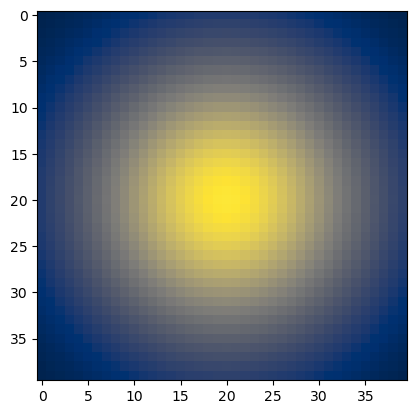

In [17]:
x = np.arange(605, 1445, 21)
y = np.arange(605, 1445, 21)

#x = np.arange(550, 1050, 26)
#y = np.arange(550, 1050, 26)

xv, yv = np.meshgrid(x, y, indexing='ij')

def hypergaussian(peak, expon, stdev_x=1, xv = xv, yv = yv, pos_x=1024, pos_y=1024):
    r2 = ((xv-pos_x)/np.sqrt(2)/(64*stdev_x))**2 + ((yv-pos_y)/np.sqrt(2)/(64*stdev_x))**2
    return peak * np.exp(-r2**expon)


z2 = hypergaussian(0.8, 1, 3.5)
plt.imshow(z2)

In [18]:
"""Making new training and testing data, by now having the output as the resolved images"""

y_train_new = np.array([hypergaussian(train_sample[0], train_sample[1], train_sample[2], xv=xv, yv=yv)
 for i, train_sample in enumerate(y_train)])
y_test_new = np.array([hypergaussian(test_sample[0], test_sample[1], test_sample[2], xv=xv, yv=yv)
 for i, test_sample in enumerate(y_test)])

y_train_new.shape

(2881, 40, 40)

## Comsol data and preprocessing

In [19]:
def interpolate_comsol(comsol, x_train):
    x_dist = np.linspace(0, x_train[0].shape[0], comsol.shape[0])
    x_dist_new = np.arange(0, x_train[0].shape[0])

    dens = []

    for i in range(0, comsol.shape[1]):
        
        intensity_new = interpolate.interp1d(x_dist, comsol[:, i])(x_dist_new)
        dens.append(intensity_new)

    dens = np.array(dens)
    return dens

    #This function is used to make sure the comsol data is interpolated to the same grid as the FDTD data

In [20]:
comsol_output = np.loadtxt('03_files/sims_comsol/comsol_parameter_values.txt').T #the true parameter values
print(f'COMSOL output shape:{comsol_output.shape}')

comsol = None
for i in range(7):

    c = np.loadtxt('03_files/sims_comsol/{}.txt'.format(str(i+1)), skiprows=8)[:, 1:]
    if comsol is None:
        comsol = c
    else:
        comsol = np.concatenate((comsol, c), axis=1)

comsol = np.array(comsol) #the complete dataset, concatenated

print(f'COMSOL data shape:{comsol.shape}')

comsol_no_plasma = np.loadtxt('03_files/sims_comsol/quartz_half_wavelength.txt', skiprows=8)[:, 1:] #the reference case

print(f'COMSOL reference shape:{comsol_no_plasma.shape}')



COMSOL output shape:(3599, 3)
COMSOL data shape:(1008, 3599)
COMSOL reference shape:(1008, 1)


(array([512], dtype=int64), array([0], dtype=int64))
(array([524], dtype=int64), array([0], dtype=int64))


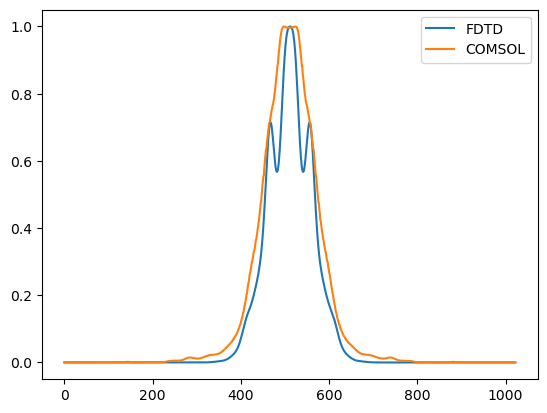

In [21]:
no_field_data = np.loadtxt('03_files/sims_FDTD/nepeak_0.000000__exponent_1.000000__stdev_0.txt', skiprows = 2)[:, 0].reshape((-1, 1))
no_field_data.shape #check with the reference for FDTD, to see how similar they are. Should in principle be exactly the same, please chrissy x

# Try to get the closest agreement between the two, to figure out how the fields must look like.
#This cell and the next are used to match the comsol data to the FDTD data, and to make sure the comsol data is interpolated to the same grid as the FDTD data
#For this, we have to cut off at the sides (or add, in this case) and to move bit left/right

comsol_no_plasma_new = np.pad(comsol_no_plasma[:, 0], (171, 171), 'edge').reshape((-1, 1))

#FDTD = comsol[:, 3]
FDTD = interpolate_comsol(no_field_data, x_train).T

comsol_no_plasma_new = interpolate_comsol(comsol_no_plasma_new, x_train).T

plt.plot(FDTD/np.max(FDTD), label='FDTD')
plt.plot(comsol_no_plasma_new/np.max(comsol_no_plasma_new), label='COMSOL')


plt.legend()
# Find the index of the maximum value in comsol
max_index_comsol = np.where(FDTD == max(FDTD))
print(max_index_comsol)

# Find the index of the maximum value in comsol_no_plasma
max_index_comsol_no_plasma = np.where(comsol_no_plasma_new == max(comsol_no_plasma_new))
print(max_index_comsol_no_plasma)
#// find the index of the maximum value in comsol and in comsol_no_plasma


In [22]:
def preProcessing_comsol(y_df, X_comsol, x_train_FDTD, no_plasma, test_size=0.2, random_state=0, noise=False, var_noise=0.01):
    #the plots are just to see the effect of interpolating and adding the padding, this is to make comsol as similar as possible, good preprocessing
    #plt.plot(X_comsol[:, 0], label='1')
    #plt.plot(no_plasma[:, 0], label='2')

    no_plasma = np.pad(no_plasma[:, 0], (171, 171), 'edge').reshape((-1, 1)) #pad as before, with the legths defined as found in the previous cell
    no_plasma = interpolate_comsol(no_plasma, x_train_FDTD) #then interpolate to FDTD data length
    
    X_comsol = np.pad(X_comsol, ((171, 171), (0, 0)), 'edge') #here, a shift can be introduced, to make sure the peak is at the same position
    X_comsol = interpolate_comsol(X_comsol, x_train_FDTD)

    #plt.plot(no_plasma[0], label='3')
    #plt.plot(X_comsol[0, :], label='4')
    #plt.legend() #previous five lines can be deleted
    #X_comsol -= no_plasma #experiment with this!
    #plt.show()

    X = np.expand_dims(np.array(X_comsol), -1) #needed for the convolutional structure
    y = np.array(y_df)

    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train_com, y_train_com = X[train_idx], y[train_idx]
    x_test_com, y_test_com = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train_com))
    x_train_com /= highest_peak
    x_test_com  /= highest_peak

    new_max = np.amax(abs(x_train_com))
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train_com):
            x_train_com[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test_com):
            x_test_com[i] = add_noise(sample, var_noise*new_max)

    return x_train_com, y_train_com, x_test_com, y_test_com, no_plasma/highest_peak, highest_peak


In [23]:
x_train_com, y_train_com, x_test_com, y_test_com, no_plasma_com, highest_peak = preProcessing_comsol(comsol_output, comsol, x_train_FDTD=x_train, no_plasma=comsol_no_plasma, noise=True, var_noise=0.01)
x_train_com_2, y_train_com_2, x_test_com_2, y_test_com_2, no_plasma_com_2, highest_peak_2 = preProcessing_comsol(comsol_output, comsol, x_train_FDTD=x_train, no_plasma=comsol_no_plasma, noise=True, var_noise=0.02)
x_train_com_3, y_train_com_3, x_test_com_3, y_test_com_3, no_plasma_com_3, highest_peak_3 = preProcessing_comsol(comsol_output, comsol, x_train_FDTD=x_train, no_plasma=comsol_no_plasma, noise=True, var_noise=0.03)
x_train_com_4, y_train_com_4, x_test_com_4, y_test_com_4, no_plasma_com_4, highest_peak_4 = preProcessing_comsol(comsol_output, comsol, x_train_FDTD=x_train, no_plasma=comsol_no_plasma, noise=True, var_noise=0.04)

x_train_com_1, y_train_com_1, x_test_com_1, y_test_com_1, no_plasma_com1, highest_peak1 = preProcessing_comsol(comsol_output, comsol, x_train_FDTD=x_train, no_plasma=comsol_no_plasma, noise=False)

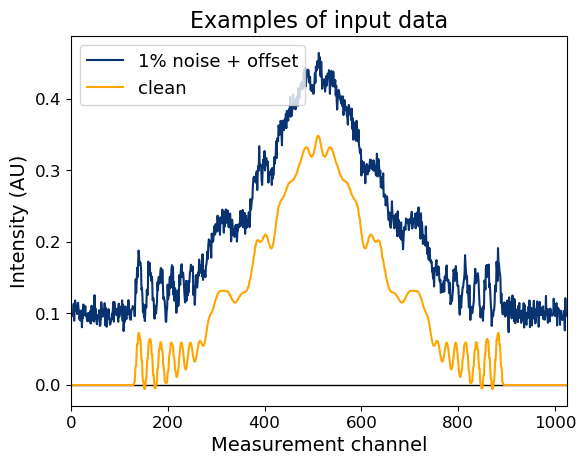

In [24]:
fig, ax = plt.subplots()

ax.hlines(0, xmin=0, xmax=1024, color='black', linewidth=1)
ax.plot(x_train_com[800, :, 0]+.038, c=colors[0], label='1% noise + offset')
#ax.plot(x_train_com_2[800, :, 0]+.188, c=colors[2], label='2%')
#ax.plot(x_train_com_3[800, :, 0]+.338, c=colors[4], label='3%')
#ax.plot(x_train_com_4[800, :, 0]+.488, c=colors[6], label='4%')

ax.plot(x_train_com_1[800, :, 0]-.062, c='orange', label='clean')
ax.legend(loc='upper left', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Examples of input data', fontsize=16)
ax.set_ylabel(r'Intensity (AU)', fontsize=14)
ax.set_xlabel(r'Measurement channel', fontsize=14)

plt.xlim(0, 1024)

plt.savefig('03_files/figures/input_data.pdf', bbox_inches='tight')

In [25]:
"""Making new training and testing data, by now having the output as the resolved images"""

y_train_com_new = np.array([hypergaussian(train_sample[0], train_sample[1], train_sample[2], xv=xv, yv=yv)
 for i, train_sample in enumerate(y_train_com)])
y_test_com_new = np.array([hypergaussian(test_sample[0], test_sample[1], test_sample[2], xv=xv, yv=yv)
 for i, test_sample in enumerate(y_test_com)])

## The loss functions

In [26]:
def mse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))

    return mse 

def rmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)

    return rmse

def nrmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)
    min_val = K.min(y_true)
    max_val = K.max(y_true)
    return rmse / (max_val - min_val)

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# For evaluation

from skimage.metrics import structural_similarity as ssim

#non-differentiable, don't use for training!

def ssim_loss(y_true, y_pred):
    # Define the custom loss function here
    return  ssim(y_true, y_pred, multichannel=True)

def psnr(y_true, y_pred):
    max_pixel = K.max(y_true)
    return 20 * K.log(max_pixel / K.sqrt(K.mean(K.square(y_true - y_pred)))) / K.log(10.0)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))


def loss_split(y_true, y_pred, frac=0.5):
    return frac*SSIMLoss(y_true, y_pred) + (1-frac)*nrmse(y_true, y_pred)

# Model generation

In [27]:
def create_resolved_model(hp):

    model = tf.keras.models.Sequential()

    model.add(layers.AveragePooling1D(pool_size=5, strides=4, padding='same', name='pool1'))

    for i in range(hp.Int("num__conv_layers", 2, 3, default=3)):

        kernelsize = int(np.max([3, (2**(4-i)-1)]))
        model.add(layers.Conv1D(np.min([8*(2**i), 32]), kernel_size=kernelsize, padding='same', name=f'conv{i+1}'))
        model.add(layers.LeakyReLU())
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2, strides=2,padding='same', name=f'pool{i+2}'))

    model.add(layers.Flatten(name='flatten'))

    rate = hp.Choice(f'droprate', [.1, .2, .25], default=.2)
    for i in range(hp.Int("num__dens_layers", 1, 3, default=3)):
        if hp.Boolean("dropout", default=True):
            model.add(keras.layers.Dropout(rate=rate, name=f'drop{i+1}'))
        model.add(layers.Dense(units=hp.Int(f"units_{i+1}", min_value=500, max_value=1500, step=250, default=1250)
                                        , activation='relu', name=f'dens{i+1}'))

    model.add(layers.Reshape((5, 5, -1)))

    model.add(layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
   
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    model.add(layers.Conv2D(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='relu'))
    """
    lr_schedule = schedules.ExponentialDecay(
                    initial_learning_rate=1e-2,
                    decay_steps=50,
                    decay_rate=0.9)
    """
    optimizer = getattr(tf.keras.optimizers, "Adam")(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=0.0032))
    loss_func = hp.Choice("loss_func", ["nrmse", "ssim", "loss_split"], default="loss_split")
    if loss_func == "nrmse":
        model.compile(optimizer=optimizer, loss=nrmse)
    elif loss_func == "ssim":
        model.compile(optimizer=optimizer, loss=SSIMLoss)
    elif loss_func == "loss_split":
        model.compile(optimizer=optimizer, loss=loss_split)

    return model


# Tuning hyperparameters

In [17]:
#This lets you tune single parameters or a few at once, with the rest set to standard value.

#For the others, the default is set inside the function create_resolved_model

hp = keras_tuner.HyperParameters()

#so only the following are tunable
hp.Int("num__conv_layers", 2, 3)
hp.Int("num__dens_layers", 1, 3)
hp.Int(f"units_{1}", min_value=500, max_value=1500, step=250)
hp.Choice(f'droprate', [.1, .2, .25])
hp.Int(f"units_{2}", min_value=500, max_value=1500, step=250)
hp.Int(f"units_{3}", min_value=500, max_value=1500, step=250)
hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")



0.0001

In [18]:
tuner = BayesianOptimization(
    hypermodel=create_resolved_model,
    hyperparameters=hp,
    # Prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective="val_loss",
    max_trials=100,
    alpha=2e-3,
    beta=2.6,
    executions_per_trial=1,
    overwrite=True,
    directory="03_files/tuning",
    project_name="COMSOL_tuning"
)

In [44]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
num__conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
num__dens_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 1500, 'step': 250, 'sampling': 'linear'}
droprate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.25], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 1500, 'step': 250, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 1500, 'step': 250, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [41]:
#tuner.search(x_train_com, y_train_com_new, validation_split=0.2, epochs=75, batch_size=64)

In [42]:
vals = tuner.get_best_hyperparameters()[0].values
vals

IndexError: list index out of range

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 1024, 1))
best_model.summary()
save_model(best_model, "03_files/tuning/best_model.h5")

In [45]:
model_result = load_model("03_files/tuning/best_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})


In [46]:
model_result.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pool1 (AveragePooling1D)    (None, 256, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 256, 8)            128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 8)            0         
                                                                 
 batch_normalization (BatchN  (None, 256, 8)           32        
 ormalization)                                                   
                                                                 
 pool2 (MaxPooling1D)        (None, 128, 8)            0         
                                                                 
 conv2 (Conv1D)              (None, 128, 16)           912       
                                                        

In [47]:
hp_opt = keras_tuner.HyperParameters()


hp_opt.Choice(f'droprate', [.1, .15, .2])
hp_opt.Int(f"units_{2}", min_value=500, max_value=500, step=250)



500

In [48]:
tuner2 = GridSearch(
    hypermodel=create_resolved_model,
    hyperparameters=hp_opt,
    # Prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="03_files/tuning",
    project_name="COMSOL_tuning_2"
)

In [49]:
tuner2.search_space_summary()

Search space summary
Default search space size: 2
droprate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.2], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 500, 'max_value': 500, 'step': 250, 'sampling': 'linear'}


In [50]:
#tuner2.search(x_train_com, y_train_com_new, validation_split=0.2, epochs=100, batch_size=64)

# Retraining ideal model

With these values, we can now retrain the model, and also try the other two loss functions to see if there is a difference.

In [58]:
vals = tuner2.get_best_hyperparameters(3)
vals[0].values

{'droprate': 0.2,
 'units_2': 500,
 'num__conv_layers': 3,
 'num__dens_layers': 3,
 'dropout': True,
 'units_1': 1250,
 'units_3': 1250,
 'learning_rate': 0.0032}

In [28]:
hp_nrmse = keras_tuner.HyperParameters()


hp_nrmse.Int(f"units_{2}", min_value=500, max_value=500, step=250)
hp_nrmse.Choice(f"loss_func", values=['nrmse'])

'nrmse'

In [69]:
hp_ssim = keras_tuner.HyperParameters()


hp_ssim.Int(f"units_{2}", min_value=500, max_value=500, step=250)
hp_ssim.Choice(f"loss_func", values=['ssim'])

'ssim'

In [ ]:
model_split = create_resolved_model(vals[0])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('03_files/tuning/optimised_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_split = model_split.fit(x_train_com, y_train_com_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

In [29]:
model_nrmse = create_resolved_model(hp_nrmse)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('03_files/tuning/nrmse_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_nrmse = model_nrmse.fit(x_train_com, y_train_com_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

Epoch 1/400
36/36 [==============================] - 6s 80ms/step - loss: 0.2721 - val_loss: 0.2673
Epoch 2/400
36/36 [==============================] - 2s 63ms/step - loss: 0.2289 - val_loss: 0.2543
Epoch 3/400
36/36 [==============================] - 2s 55ms/step - loss: 0.1921 - val_loss: 0.3055
Epoch 4/400
36/36 [==============================] - 2s 45ms/step - loss: 0.1250 - val_loss: 0.3530
Epoch 5/400
36/36 [==============================] - 2s 44ms/step - loss: 0.1041 - val_loss: 0.4388
Epoch 6/400
36/36 [==============================] - 2s 43ms/step - loss: 0.0946 - val_loss: 0.4024
Epoch 7/400
36/36 [==============================] - 2s 43ms/step - loss: 0.0838 - val_loss: 0.4204
Epoch 8/400
36/36 [==============================] - 2s 42ms/step - loss: 0.0760 - val_loss: 0.4754
Epoch 9/400
36/36 [==============================] - 2s 43ms/step - loss: 0.0688 - val_loss: 0.5178
Epoch 10/400
36/36 [==============================] - 2s 43ms/step - loss: 0.0719 - val_loss: 0.4797

In [ ]:
model_ssim = create_resolved_model(hp_ssim)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('03_files/tuning/ssim_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_ssim = model_ssim.fit(x_train_com, y_train_com_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

In [32]:
optimised_result = load_model("03_files/tuning/optimised_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
ssim_result = load_model("03_files/tuning/ssim_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
nrmse_result = load_model("03_files/tuning/nrmse_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})


In [22]:
nrmse_result.nrmse = model_nrmse.evaluate(x_test_com, y_test_com_new)

23/23 [==============================] - 0s 10ms/step - loss: 0.0418


23/23 [==============================] - 1s 20ms/step - loss: 0.0370


C:\Users\ewout\AppData\Local\Temp\ipykernel_21264\2658906077.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, .05, .1, .15, .2], fontsize=12) # Set label locations.
C:\Users\ewout\AppData\Local\Temp\ipykernel_21264\2658906077.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=12) # Set label locations.


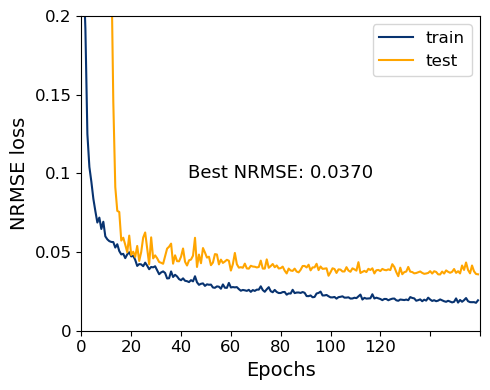

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(history_nrmse.history['loss'],c=colors[0], label='train')
ax.plot(history_nrmse.history['val_loss'], c='orange',  label='test')
ax.annotate(f'Best NRMSE: {model_nrmse.evaluate(x_test_com, y_test_com_new):.4f}', xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=13)

#ax.yscale('log')
ax.legend(fontsize=12)
ax.set_ylim(0, .2)
ax.set_xlim(0, 200)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_yticklabels([0, .05, .1, .15, .2], fontsize=12) # Set label locations.
ax.set_xticklabels([0, 20, 40, 60, 80, 100, 120], fontsize=12) # Set label locations.
ax.set_yticks(np.arange(0, .21, step=0.05)) # Set label locations.
ax.set_ylabel('NRMSE loss', fontsize=14)
plt.tight_layout()


## Compare again

In [43]:
def ResCompareProfiles(model, x, y, save_figures=False, threeD=False):
    index = 0
    counter = 0
    while index != -1:
        counter +=1
        clear_output()
        plt.set_cmap('cividis')

        prediction = model.predict(np.expand_dims(x[index], 0)).reshape((40, 40))
        print(prediction.shape)
        truth = y[index].reshape((40, 40))


        fig, ax = plt.subplots(1, 3, figsize=(11, 3))

        ax[0].fill_between(np.arange(0, 40), 0, np.diag(prediction), color=colors[0], alpha=0.1)

        im_true = ax[0].plot(np.diag(truth), label='Ground truth', linestyle='--', c='orange')
        ax[0].set_xlabel('Position on diagonal', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(np.diag(prediction), label='Prediction', c=colors[0])
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, 1))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        
        #true = ax[1].imshow(norm_true, vmax=255, vmin=(min_value*255).astype(int))
        true = ax[1].imshow(truth, vmax=0.8, vmin=0)
        #true = ax[1].contourf(truth, vmax=0.8, vmin=0, levels=200)
        ax[1].contour(truth, levels=np.arange(0.05, 1, .05), colors='black', linewidths=.7)
        ax[1].set_title('True profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        #ax[2].imshow(norm_pred, vmax=255, vmin=(min_value*255).astype(int))
        ax[2].contourf(prediction, vmax=0.8, vmin=0, levels=200)
        ax[2].contour(prediction, levels=np.arange(0.05, 1, .05), colors='black', linewidths=.7)
        #ax[2].imshow(prediction, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725]) # [left, bottom, width, height] 
        #//make the cbar_ax above be abit closer to the ax[2] figure
        cbar = fig.colorbar(true, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)
        if save_figures:
            plt.savefig(f'03_files/figures/compare/{counter}.png', dpi=300)
        


        plt.show()

        if threeD: 
            fig = plt.figure(figsize=(8, 4))

            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            X, Y = np.meshgrid(np.arange(truth.shape[1]), np.arange(truth.shape[0]))
            ax1.plot_surface(X, Y, truth, vmax=0.8, vmin=0, cmap='cividis')
            ax1.set_zlim(0, 0.8)
            ax1.set_title('True profile')
            ax2.plot_surface(X, Y, prediction, vmax=0.8, vmin=0, cmap='cividis')
            ax2.set_zlim(0, 0.8)
            ax2.set_title('Predicted profile')

            plt.show()

        index = int(input(f"Select new index, -1 to stop: "))

    return


1/1 [==============================] - 0s 23ms/step
(40, 40)


<Figure size 640x480 with 0 Axes>

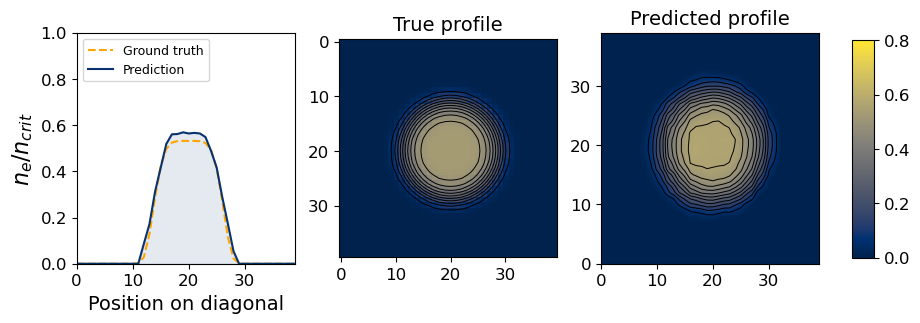

In [44]:
ResCompareProfiles(optimised_result, x_test_com, y_test_com_new, save_figures=True, threeD=False)

In [45]:
import os

os.system("ffmpeg  -r 1/1.5 -i ./figures/compare/%d.png -vcodec mpeg4 -y ./figures/compare/profiles.mp4")

1

In [20]:
predictions_split = optimised_result.predict(x_test_com)
predictions_ssim = ssim_result.predict(x_test_com)
predictions_nrmse = nrmse_result.predict(x_test_com)

23/23 [==============================] - 0s 9ms/step


In [21]:
def get_peak(elem):
    return elem[0]

y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test_com[:, 0], y_test_com_new), key=get_peak)])
pred_split_sorted = np.array(sorted(zip(y_test_com[:, 0], predictions_split), key=get_peak)) #change back to resolved_a here later
pred_ssim_sorted = np.array(sorted(zip(y_test_com[:, 0], predictions_ssim), key=get_peak))
pred_nrmse_sorted = np.array(sorted(zip(y_test_com[:, 0], predictions_nrmse), key=get_peak))

densities_com = y_sorted[:, 0]

#densities_com = densities_com[:500]

MAE_split_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_split_sorted[i, 1]) for i in range(len(densities_com))])
MAE_ssim_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_ssim_sorted[i, 1]) for i in range(len(densities_com))])
MAE_nrmse_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_nrmse_sorted[i, 1]) for i in range(len(densities_com))])

C:\Users\ewout\AppData\Local\Temp\ipykernel_11372\1181952463.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test_com[:, 0], y_test_com_new), key=get_peak)])
C:\Users\ewout\AppData\Local\Temp\ipykernel_11372\1181952463.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_split_sorted = np.array(sorted(zip(y_test_com[:, 0], predictions_split), key=get_peak)) #change back to resolved_a here later
C:\Users\ewout\AppData\Local\Temp\ipykernel_11372\11819524

In [22]:
print(np.mean(MAE_split_sorted))
print(np.mean(MAE_ssim_sorted))
print(np.mean(MAE_nrmse_sorted))


0.0178310828669255
0.024214717745754812
0.02001332396661892


float64


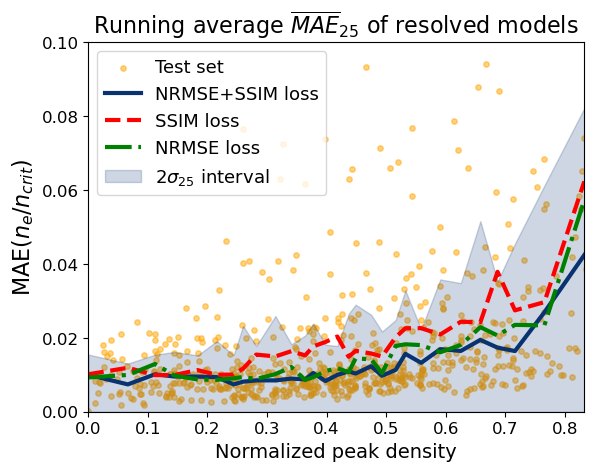

In [28]:
fig, ax = plt.subplots()

ax.scatter(densities_com, MAE_split_sorted, s=15, alpha=0.5, c='orange', label='Test set')
#ax.scatter(densities, MAE_split_sorted_parametric, s=4, c='indianred', label = 'Parametric')


mean_25_split = []
mean_25_ssim = []
mean_25_nrmse = []
stdev_25 = []

for i in range(0 , len(MAE_split_sorted), 25): 
    #// Also calculate the standard deviation of the 25 points
    mean_25_split_points = sum(MAE_split_sorted[i:i+25])/25  # Calculate mean of 10 points  
    mean_25_ssim_points = sum(MAE_ssim_sorted[i:i+25])/25  # Calculate mean of 10 points
    mean_25_nrmse_points = sum(MAE_nrmse_sorted[i:i+25])/25  # Calculate mean of 10 points

    med_25_split_points = np.median(MAE_split_sorted[i:i+25])  # Calculate mean of 10 points
    med_25_ssim_points = np.median(MAE_ssim_sorted[i:i+25])  # Calculate mean of 10 points
    med_25_nrmse_points = np.median(MAE_nrmse_sorted[i:i+25])  # Calculate mean of 10 points


    mean_25_split.append(med_25_split_points) # Append the values in the list  
    mean_25_ssim.append(med_25_ssim_points) # Append the values in the list
    mean_25_nrmse.append(med_25_nrmse_points) # Append the values in the list

    #change the lines above back to mean when you want to use mean instead of median

    variance_25 = sum(((MAE_split_sorted[i:i+25] - mean_25_split_points) ** 2)) / 25 
    stdev_25.append(variance_25**0.5)


     # Plot the line graph
ax.plot(densities_com[::25],mean_25_split, c=colors[0], linewidth=3, linestyle='-', label=r'NRMSE+SSIM loss')
ax.plot(densities_com[::25],mean_25_ssim, c='red', linewidth=3, linestyle='--', label=r'SSIM loss')
ax.plot(densities_com[::25],mean_25_nrmse, c='green', linewidth=3, linestyle='-.', label=r'NRMSE loss')

ax.fill_between(np.array(densities_com[::25], dtype=float), 0,
 np.array(mean_25_split, dtype=float) + np.array(stdev_25, dtype=float), color=colors[0], alpha=0.2, label=r'$2\sigma_{25}$ interval')
 # label=r'$\overline{MAE}_{25} + 2\sigma_{25}$'

ax.legend(loc='upper left', fontsize=13)
ax.set_ylim((0, .1))
ax.set_xlim((0, densities_com[::25][-1]))


ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Running average $\overline{MAE}_{25}$ of resolved models', fontsize=16)
ax.set_xlabel(r'Normalized peak density', fontsize=14)
ax.set_ylabel(r'MAE($n_e/n_{crit}$)', fontsize=16)


print(np.array(densities_com[::25], dtype=float).dtype)

plt.savefig('03_files/figures/Com_MAE_resolved.pdf', bbox_inches='tight')


# Full comparison and quantitative measures

In [24]:
print(np.mean(mae(y_test_com_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(mae(y_test_com_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(mae(y_test_com_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(0.0178310828669255, shape=(), dtype=float64)
tf.Tensor(0.024214717745754812, shape=(), dtype=float64)
tf.Tensor(0.020013323966618923, shape=(), dtype=float64)


In [25]:
print(np.mean(nrmse(y_test_com_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(nrmse(y_test_com_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(nrmse(y_test_com_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(0.03120759547205812, shape=(), dtype=float64)
tf.Tensor(0.04291823134811827, shape=(), dtype=float64)
tf.Tensor(0.03599124752504679, shape=(), dtype=float64)


In [26]:
print(np.mean(ssim_loss(y_test_com_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(ssim_loss(y_test_com_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(ssim_loss(y_test_com_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

0.9797773379010388


C:\Users\ewout\AppData\Local\Temp\ipykernel_11372\1319621768.py:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return  ssim(y_true, y_pred, multichannel=True)
c:\Users\ewout\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


0.9706019679033492
0.97311960241754


In [27]:
print(np.mean(psnr(y_test_com_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(psnr(y_test_com_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(psnr(y_test_com_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(30.114793425700057, shape=(), dtype=float64)
tf.Tensor(27.347163290788632, shape=(), dtype=float64)
tf.Tensor(28.876061591285136, shape=(), dtype=float64)
